In [2]:
%matplotlib inline
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from scikeras.wrappers  import KerasClassifier
import nltk
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [4]:
import os
import pandas as pd

dataset_path = "D:/Masters/Sem 2/Machine learning/Datasets/aclImdb"  

# used internet help to extract the file data into a dataframe, i commented every line explaining what they do
# list for storing reviews text, its label pos,neg, review ids and rating
reviews = []
labels = []
file_ids = []
ratings = []

# dictionaries for looping as files are in train and test folder and positive and negative folder
splits = ["train", "test"]
sentiments = ["pos", "neg"]

# Loop through train/test and pos/neg directories
for split in splits: # getting the folder name train and then test
    for sentiment in sentiments: # getting the folder name pos and neg folders in train and then test folder
        folder_path = os.path.join(dataset_path, split, sentiment) # joining folder path 
        
        # Iterate over all files in the directory
        for filename in os.listdir(folder_path): # getting every file name 
            if filename.endswith(".txt"): # getting only text files
                file_path = os.path.join(folder_path, filename) # joining the file path for every text files 
                
                # Extract ID and rating from filename (if file name is 100_7 then id is 100 and reting is 7)
                file_id, rating = filename.split("_") # spliting the string by _
                rating = rating.replace(".txt", "")  # removing the .txt 
                
                # Read the review text
                with open(file_path, "r", encoding="utf-8") as file: 
                    review_text = file.read().strip()
                
                # Assigning numeric label: 1 for positive, 0 for negative
                label = 1 if sentiment == "pos" else 0
                
                # Append data to lists
                reviews.append(review_text)
                labels.append(label)
                file_ids.append(file_id)
                ratings.append(int(rating))

# Converting list to DF
df = pd.DataFrame({
    "id": file_ids,
    "review": reviews,
    "label": labels,
    "rating": ratings
})

print(df.head())


      id                                             review  label  rating
0      0  Bromwell High is a cartoon comedy. It ran at t...      1       9
1  10000  Homelessness (or Houselessness as George Carli...      1       8
2  10001  Brilliant over-acting by Lesley Ann Warren. Be...      1      10
3  10002  This is easily the most underrated film inn th...      1       7
4  10003  This is not the typical Mel Brooks film. It wa...      1       8


In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = word[1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
class SimpleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        self.stopwords = set(ENGLISH_STOP_WORDS)
        self.lemmatizer = WordNetLemmatizer()


    def transform(self, x, fit=False):
        matrix = []
        i = 0;
        for sentence in x:
            tokens = self.tokenizer.tokenize(sentence.lower())
            tokens_tags = nltk.pos_tag(tokens)   
            tokens = [self.lemmatizer.lemmatize(item[0], get_wordnet_pos(item)) for item in tokens_tags \
                      if item[1] not in ['MD','IN', 'FW', 'EX','PDT','POS', 'PRP$','PRP', 'UH', 'WDT', 'WRB','WP','WP$']
                     and item[0] != 'br']  # file had <br> tag so many time so i removed it 
            tokens = [word for word in tokens if word not in self.stopwords and len(word) > 1]
            
            matrix.append(tokens)
            
            if i % 50 == 0:
                print(i)
            i = i + 1
                              
        return matrix

In [6]:
tokenzier = SimpleTransformer()
tokens = tokenzier.transform(df['review'])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

In [7]:
from nltk import FreqDist
fdist = FreqDist(np.concatenate(tokens)) 
for word, frequency in fdist.most_common(2000):
    print(u'{};{}'.format(word, frequency))

movie;103280
film;95362
make;45184
good;37195
just;35184
time;31617
character;28361
watch;27517
bad;26303
story;25244
really;23094
think;23031
scene;21090
great;20083
look;19906
say;19267
end;18893
know;18873
people;18384
don;17658
way;17231
love;16840
play;16826
thing;16508
come;16473
life;14733
work;13736
plot;13731
actor;13568
year;13243
want;13108
best;12626
try;12460
little;12442
man;11922
act;10886
ve;10150
old;10081
director;10048
use;9772
lot;9720
funny;9719
real;9431
guy;9200
performance;8988
woman;8905
doesn;8875
didn;8765
10;8625
star;8584
big;8513
actually;8470
role;8302
new;8233
young;8156
tell;8119
start;8097
leave;8090
feel;8035
point;8028
cast;8000
like;7937
day;7847
girl;7805
world;7726
turn;7559
horror;7492
long;7461
minute;7425
comedy;7409
fact;7343
pretty;7272
quite;7191
action;7156
write;7146
set;7097
kill;6939
right;6902
happen;6859
line;6836
fan;6706
far;6625
series;6556
bit;6529
need;6506
music;6477
script;6460
friend;6454
enjoy;6443
acting;6438
original;6410
sa

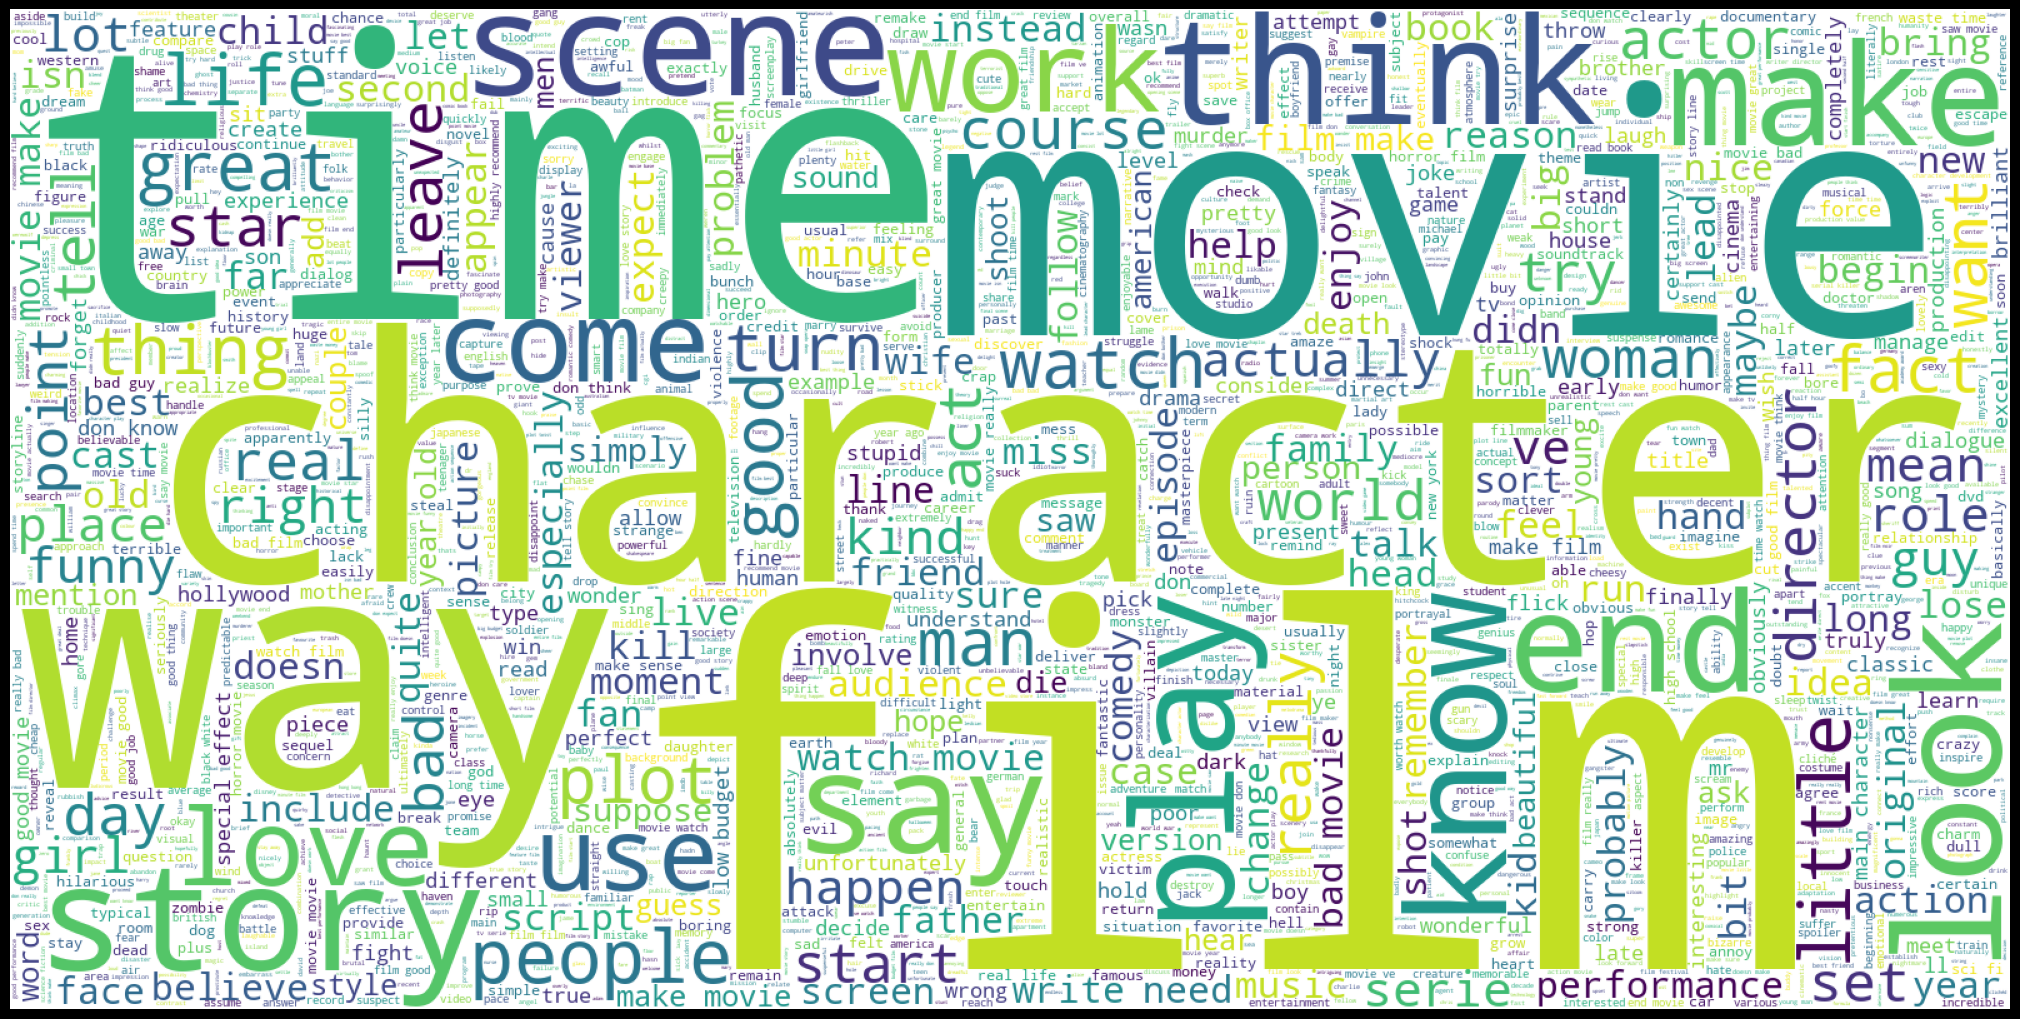

In [8]:
from wordcloud import WordCloud
# Join the different processed titles together.
flatten_list = [j for sub in tokens for j in sub]
long_string = ','.join(flatten_list)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white",width=1600, height=800, max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [9]:
import sklearn 
X, test, y, y_test = sklearn.model_selection.train_test_split(tokens, df['label'], stratify=df['label'], 
                                                              test_size=.15)

In [10]:
pd.Series(y).value_counts()

label
1    21250
0    21250
Name: count, dtype: int64

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=.01, max_df=.99, max_features=10_000, lowercase=False)
X2 = vectorizer.fit_transform([" ".join(x) for x in X])
test2 = vectorizer.transform([" ".join(x) for x in test])
X2.shape

(42500, 1411)

In [12]:
X3 = pd.DataFrame(X2.toarray(), columns=vectorizer.get_feature_names_out())
X3.shape

(42500, 1411)

In [17]:
def build_model():  
    model = models.Sequential()
    model.add(layers.Dense(1411, activation='relu', input_shape=(X2.shape[1],)))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(700, activation='relu'))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(1, activation='sigmoid')) # 1 output because it binary classification (either 0 or 1)
    # sigmoid activation because we dont want prob of all class like softmax, we want the actual class label
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.metrics.Recall(), 'accuracy'])      
    return model
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1411)              1992332   
                                                                 
 dropout_4 (Dropout)         (None, 1411)              0         
                                                                 
 dense_7 (Dense)             (None, 700)               988400    
                                                                 
 dropout_5 (Dropout)         (None, 700)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 701       
                                                                 
Total params: 2981433 (11.37 MB)
Trainable params: 2981433 (11.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = KerasClassifier(build_fn=build_model, epochs=5, batch_size=32, verbose=1,)
modelfit = model.fit(X2.toarray(), y)

C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
1329/1329 [==============================] - 46s 34ms/step - loss: 0.3479 - recall_3: 0.8522 - accuracy: 0.8457
Epoch 2/5
1329/1329 [==============================] - 45s 34ms/step - loss: 0.2879 - recall_3: 0.8873 - accuracy: 0.8788
Epoch 3/5
1329/1329 [==============================] - 44s 33ms/step - loss: 0.2254 - recall_3: 0.9148 - accuracy: 0.9116
Epoch 4/5
1329/1329 [==============================] - 43s 32ms/step - loss: 0.1071 - recall_3: 0.9635 - accuracy: 0.9633
Epoch 5/5
1329/1329 [==============================] - 43s 33ms/step - loss: 0.0447 - recall_3: 0.9854 - accuracy: 0.9853


In [29]:
predictedp = model.predict_proba(test2.toarray())[:, 1]  # Probability for class 1
predicted = (predictedp > 0.5).astype(int)  # Threshold at 0.5 for binary prediction
print("Predicted shape:", predicted.shape)
print("Predicted values sample:", predicted[:10])

235/235 [==============================] - 1s 3ms/step
Predicted shape: (7500,)
Predicted values sample: [1 1 0 0 1 0 0 0 0 0]


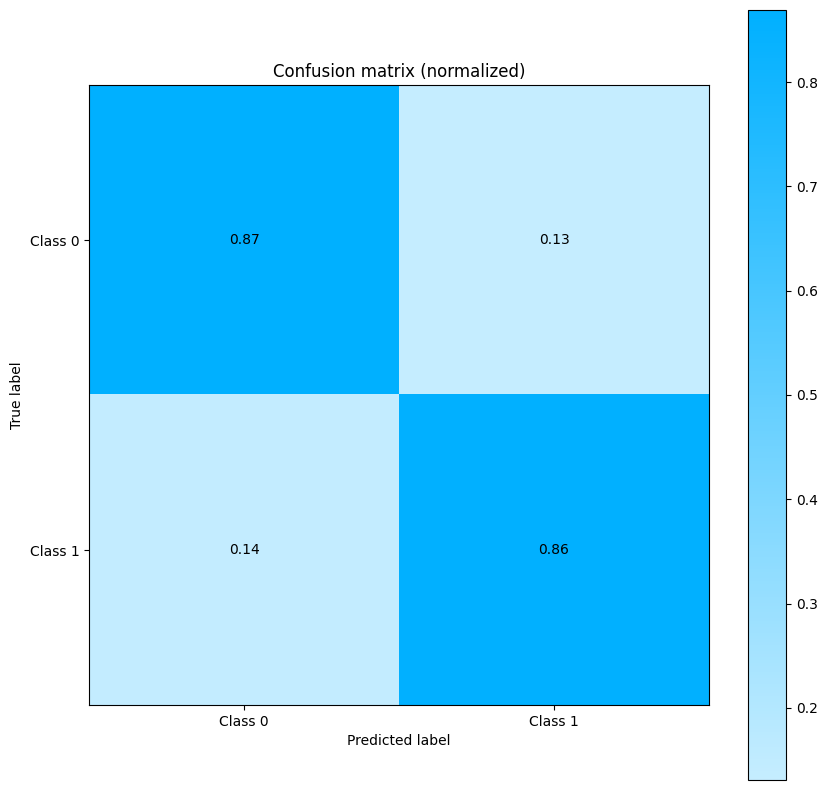

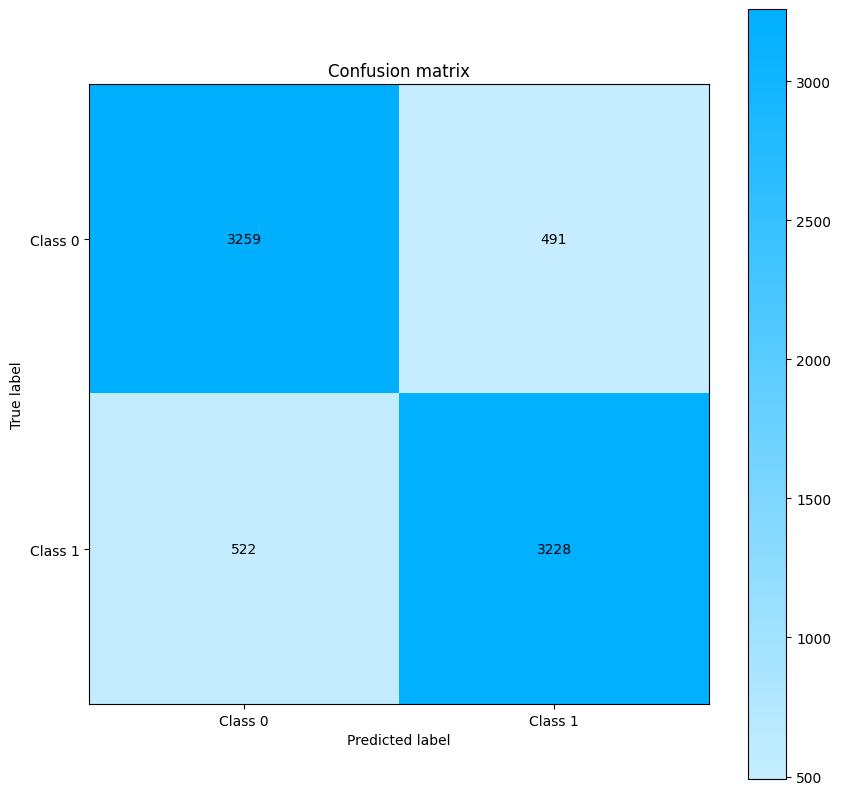

0.8649333333333333
0.8649582737707444
0.8649333333333333
0.8649310257549467


In [31]:
from sklearn_evaluation import plot
import scikitplot as skplt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [10, 10]
       
plot.confusion_matrix(y_test, predicted, normalize=True)
plt.show()
plot.confusion_matrix(y_test, predicted, normalize=False)
plt.show()

print(accuracy_score(y_test, predicted))
print(precision_score(y_test, predicted, average='macro'))
print(recall_score(y_test, predicted,average='macro'))
print(f1_score(y_test, predicted,average='macro'))
